<a href="https://colab.research.google.com/github/Motea99/Pneumonia-Diagnosis-System-Challenge/blob/main/End_To_End_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist
!pip install torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO, Evaluator
# استيراد المجموعة المطلوبة بناءً على طلبك
from medmnist import PneumoniaMNIST

# 1. إعداد الإعدادات الخاصة بـ PneumoniaMNIST
data_flag = 'pneumoniamnist'
download = True
BATCH_SIZE = 128
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])

# 2. تجهيز الصور (التحويل إلى Tensor والمعايرة)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# 3. تحميل البيانات (Train & Test)
train_dataset = PneumoniaMNIST(split='train', transform=data_transform, download=download)
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=download)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset: {info['description']}")
print(f"Number of classes: {n_classes}")

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.06MB/s]


Dataset: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
Number of classes: 2


In [ ]:
# Assuming you already defined: data_flag = 'pneumoniamnist'
# and imported: from medmnist import INFO

# 1. Access the metadata for this specific dataset
dataset_info = INFO[data_flag]

# 2. Get the dictionary of labels
label_dictionary = dataset_info['label']

# 3. Calculate the number of classes
n_classes = len(label_dictionary)

print(f"Number of classes: {n_classes}")
print(f"Class details: {label_dictionary}")

Number of classes: 2
Class details: {'0': 'normal', '1': 'pneumonia'}


In [ ]:
import numpy as np
import cv2
from torchvision import transforms
from medmnist import PneumoniaMNIST
from torch.utils.data import DataLoader

# 1. Define a custom Transform for CLAHE
class ApplyCLAHE(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        # Convert PIL image or Tensor to numpy array
        img_array = np.array(img)

        # Apply CLAHE
        clahe_img = self.clahe.apply(img_array)

        # Return as image (or it will be converted by ToTensor next)
        return clahe_img

# 2. Setup Transforms including CLAHE
# Note: CLAHE is applied BEFORE ToTensor() because it operates on 2D arrays
data_transform = transforms.Compose([
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 3. Load Datasets with the new transform
train_dataset = PneumoniaMNIST(split='train', transform=data_transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True)

# 4. Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

print("CLAHE has been applied to both Train and Test sets successfully.")

CLAHE has been applied to both Train and Test sets successfully.


In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from medmnist import PneumoniaMNIST
from torch.utils.data import DataLoader
from timm import create_model
from tqdm import tqdm

# 1. Updated Custom Transform for CLAHE
class ApplyCLAHE(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        img_array = np.array(img)
        clahe_img = self.clahe.apply(img_array)
        return clahe_img

# 2. Updated Data Transforms (Adding Resize to 224)
data_transform = transforms.Compose([
    ApplyCLAHE(),
    transforms.ToPILImage(),          # Convert back to PIL to use Resize
    transforms.Resize((224, 224)),    # <--- Critical Step for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 3. Load Datasets
train_dataset = PneumoniaMNIST(split='train', transform=data_transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) # Smaller batch for ViT

# 4. Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2, in_chans=1)
model.to(device)

# 5. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 6. Training Function (Same as before)
def train_model(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        loop = tqdm(loader)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device).squeeze().long()

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())

# Start Training
train_model(model, train_loader, criterion, optimizer, epochs=1)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 148/148 [00:23<00:00,  6.42it/s, loss=0.0525]


🔍 VIT MODEL EVALUATION SYSTEM
✅ Sample batch - Images: torch.Size([128, 1, 28, 28]), Labels: torch.Size([128, 1])
✅ Label values: tensor([0, 1])

✅ Validation passed. Starting evaluation...

📊 Detected image size: 28x28
⚠️  Image size mismatch: Got 28x28, expected 224x224
🔄 Automatically resizing images during evaluation...
✅ Automatic resizing enabled!

🚀 Starting evaluation process...
📦 Number of batches: 5


/tmp/ipython-input-3112657700.py:86: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.stack(images), torch.tensor(labels)


✅ Processed 1/5 batches
✅ Processed 2/5 batches
✅ Processed 3/5 batches
✅ Processed 4/5 batches
✅ Processed 5/5 batches

📊 Total samples evaluated: 624
📊 Class distribution: (array([0, 1]), array([234, 390]))

🎯 OVERALL ACCURACY: 0.8045 (80.45%)

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       1.00      0.48      0.65       234
   Pneumonia       0.76      1.00      0.86       390

    accuracy                           0.80       624
   macro avg       0.88      0.74      0.76       624
weighted avg       0.85      0.80      0.78       624


📊 CONFUSION MATRIX:
[[112 122]
 [  0 390]]


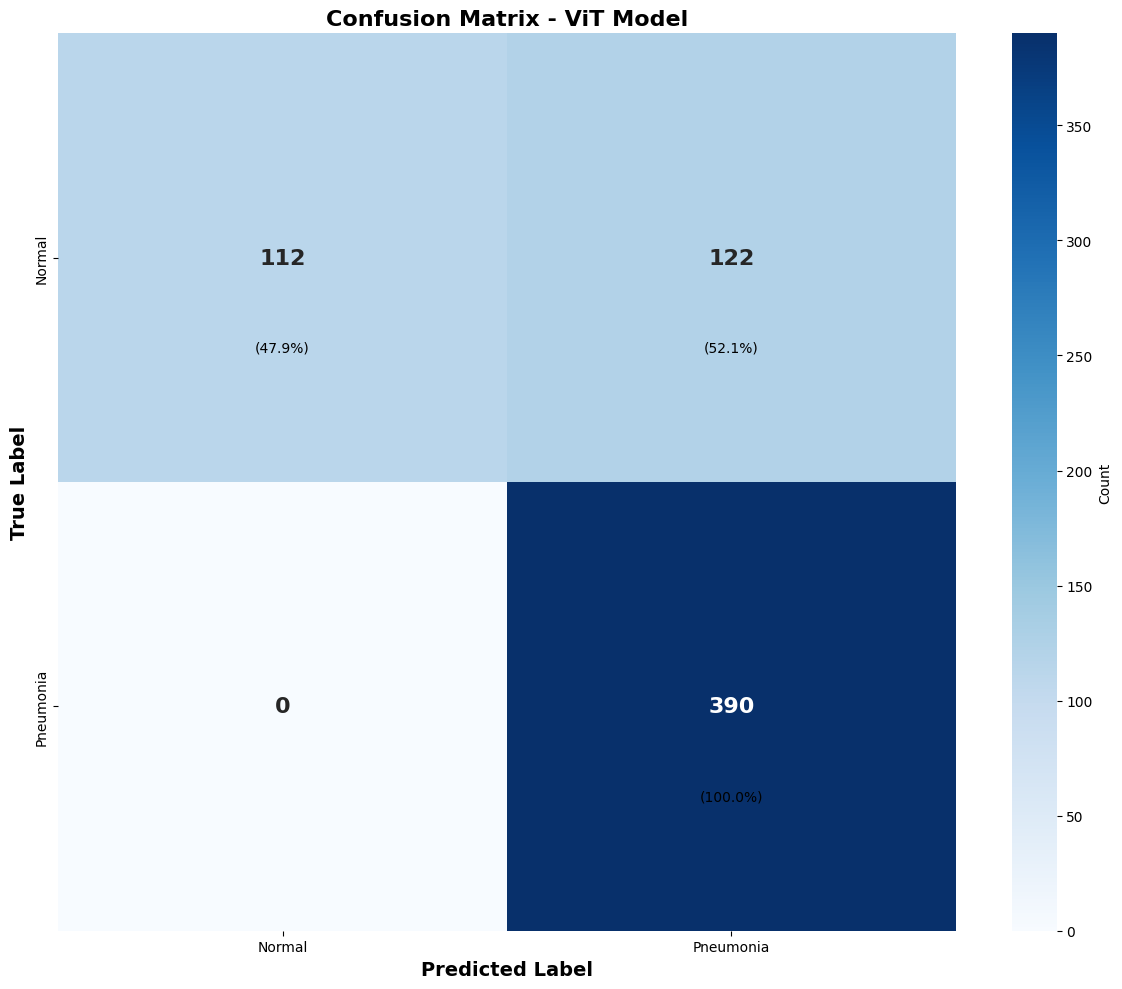


📈 DETAILED METRICS:
   • True Positives: 390
   • True Negatives: 112
   • False Positives: 122
   • False Negatives: 0
   • Sensitivity (Recall): 1.0000
   • Specificity: 0.4786
   • Precision: 0.7617
   • F1-Score: 0.8647

✨ Evaluation completed successfully!


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ============================================
# 1. التحقق من البيئة والمتطلبات الأساسية
# ============================================

def check_requirements():
    """التحقق من وجود جميع المتطلبات"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ Using device: {device}")
    print(f"✅ PyTorch version: {torch.__version__}")

    # التحقق من وجود model و test_loader
    global model, test_loader
    try:
        print(f"✅ Model type: {type(model).__name__}")
        print(f"✅ Test loader batches: {len(test_loader)}")
    except NameError:
        print("❌ Error: model or test_loader not defined!")
        return False

    return True

# ============================================
# 2. دالة لفحص وتعديل حجم الصور
# ============================================

def get_image_size_from_loader(test_loader):
    """فحص حجم الصور في test_loader"""
    for images, _ in test_loader:
        return images.shape[2:]  # (height, width)
    return None

def fix_image_size(image, target_size=(224, 224)):
    """تعديل حجم الصورة إلى الحجم المطلوب"""
    if image.shape[1:] != target_size:
        resize = transforms.Resize(target_size)
        return resize(image)
    return image

# ============================================
# 3. الدالة الرئيسية للتقييم (بدون تكرار الأرقام)
# ============================================

def evaluate_model_safe(model, test_loader):
    """
    دالة تقييم متكاملة مع معالجة تلقائية لأحجام الصور
    """
    # إعداد الجهاز
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # التحقق من حجم الصور
    sample_shape = None
    for images, _ in test_loader:
        sample_shape = images.shape
        print(f"📊 Detected image size: {sample_shape[2]}x{sample_shape[3]}")
        break

    # الحجم المتوقع للنموذج
    expected_size = 224  # ViT expects 224x224

    # إذا كان الحجم غير مناسب، نقوم بتعديله تلقائياً
    if sample_shape and (sample_shape[2] != expected_size or sample_shape[3] != expected_size):
        print(f"⚠️  Image size mismatch: Got {sample_shape[2]}x{sample_shape[3]}, expected {expected_size}x{expected_size}")
        print("🔄 Automatically resizing images during evaluation...")

        # إضافة resize transform
        resize_transform = transforms.Resize((expected_size, expected_size))

        # تعديل test_loader مؤقتاً
        original_collate = test_loader.collate_fn

        def collate_with_resize(batch):
            images = []
            labels = []
            for img, label in batch:
                if img.shape[1:] != (expected_size, expected_size):
                    img = resize_transform(img)
                images.append(img)
                labels.append(label)
            return torch.stack(images), torch.tensor(labels)

        test_loader.collate_fn = collate_with_resize
        print("✅ Automatic resizing enabled!")

    model.eval()
    all_preds = []
    all_labels = []

    print("\n🚀 Starting evaluation process...")
    print(f"📦 Number of batches: {len(test_loader)}")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            try:
                images = images.to(device)

                # التحقق من حجم الصور قبل الإدخال
                if images.shape[2:] != (expected_size, expected_size):
                    print(f"⚠️  Batch {batch_idx}: Unexpected shape {images.shape}, resizing...")
                    images = torch.stack([fix_image_size(img, (expected_size, expected_size)) for img in images])
                    images = images.to(device)

                # Forward pass
                outputs = model(images)

                # Handle Hugging Face output format
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                else:
                    logits = outputs

                # Get predictions
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Progress update
                if (batch_idx + 1) % max(1, len(test_loader)//5) == 0:
                    print(f"✅ Processed {batch_idx + 1}/{len(test_loader)} batches")

            except Exception as e:
                print(f"❌ Error in batch {batch_idx}: {e}")
                continue

    # تحويل إلى numpy
    all_labels = np.array(all_labels).flatten()
    all_preds = np.array(all_preds).flatten()

    print(f"\n📊 Total samples evaluated: {len(all_labels)}")
    print(f"📊 Class distribution: {np.unique(all_labels, return_counts=True)}")

    # حساب المقاييس
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    # التقرير الكامل
    target_names = ['Normal', 'Pneumonia']
    report = classification_report(all_labels, all_preds, target_names=target_names)

    # طباعة النتائج
    print("\n" + "="*50)
    print(f"🎯 OVERALL ACCURACY: {acc:.4f} ({acc*100:.2f}%)")
    print("="*50)
    print("\n📋 CLASSIFICATION REPORT:")
    print(report)

    print("\n📊 CONFUSION MATRIX:")
    print(cm)

    # ============================================
    # رسم Confusion Matrix بشكل صحيح (بدون تكرار)
    # ============================================
    plt.figure(figsize=(12, 10))

    # الطريقة الأولى: استخدام annot=True فقط (بدون إضافة نصوص يدوية)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                     xticklabels=target_names,
                     yticklabels=target_names,
                     annot_kws={'size': 16, 'weight': 'bold'},
                     cbar_kws={'label': 'Count'})

    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.title('Confusion Matrix - ViT Model', fontsize=16, fontweight='bold')

    # إضافة النسب المئوية في خانة منفصلة (اختياري)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                percentage = cm[i, j] / np.sum(cm[i, :]) * 100
                # إضافة النسبة المئوية أسفل الرقم الرئيسي
                ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                       ha='center', va='center', color='black', fontsize=10)

    plt.tight_layout()
    plt.show()

    # إحصائيات إضافية
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()

        print("\n📈 DETAILED METRICS:")
        print(f"   • True Positives: {tp}")
        print(f"   • True Negatives: {tn}")
        print(f"   • False Positives: {fp}")
        print(f"   • False Negatives: {fn}")

        if tp + fn > 0:
            sensitivity = tp / (tp + fn)
            print(f"   • Sensitivity (Recall): {sensitivity:.4f}")

        if tn + fp > 0:
            specificity = tn / (tn + fp)
            print(f"   • Specificity: {specificity:.4f}")

        # Precision and F1-score
        if tp + fp > 0:
            precision = tp / (tp + fp)
            print(f"   • Precision: {precision:.4f}")

        if precision + sensitivity > 0:
            f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
            print(f"   • F1-Score: {f1:.4f}")

    return acc, cm

# ============================================
# 4. التحقق من النموذج والبيانات
# ============================================

def validate_model_and_data():
    """التحقق من صحة النموذج والبيانات قبل التقييم"""

    # التأكد من وجود model
    try:
        model
    except NameError:
        print("❌ ERROR: 'model' is not defined!")
        print("Please define your model first.")
        return False

    # التأكد من وجود test_loader
    try:
        test_loader
    except NameError:
        print("❌ ERROR: 'test_loader' is not defined!")
        print("Please define your test_loader first.")
        return False

    # التأكد من أن النموذج في وضع التقييم
    model.eval()

    # فحص عينة من البيانات
    try:
        for images, labels in test_loader:
            print(f"✅ Sample batch - Images: {images.shape}, Labels: {labels.shape}")
            print(f"✅ Label values: {torch.unique(labels)}")
            break
    except Exception as e:
        print(f"❌ Error accessing test_loader: {e}")
        return False

    return True

# ============================================
# 5. التنفيذ النهائي
# ============================================

print("="*60)
print("🔍 VIT MODEL EVALUATION SYSTEM")
print("="*60)

# التحقق من المتطلبات
if validate_model_and_data():
    print("\n✅ Validation passed. Starting evaluation...\n")

    # تنفيذ التقييم
    try:
        acc, cm = evaluate_model_safe(model, test_loader)
        print("\n✨ Evaluation completed successfully!")
    except Exception as e:
        print(f"\n❌ Unexpected error during evaluation: {e}")
        print("\n🛠️  Troubleshooting tips:")
        print("   1. Check if model is correctly loaded")
        print("   2. Verify test_loader contains valid data")
        print("   3. Ensure GPU memory is sufficient")
        print("   4. Try reducing batch size if memory issues")
else:
    print("\n❌ Validation failed. Please check the errors above.")

In [ ]:

 !pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=7622502a995d310decbc48503da40b430a71aba4dc2f0cc0a5266b878788b12c
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


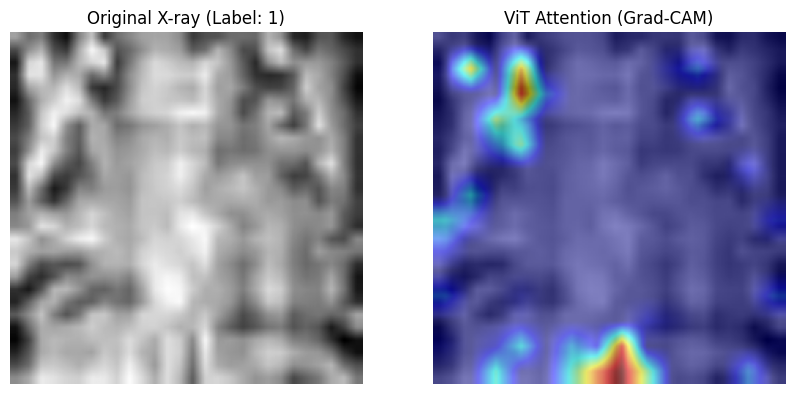

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 1. Define the reshape transform for ViT
# This function converts (Batch, Sequence_Length, Hidden_Size) -> (Batch, Hidden_Size, H, W)
def reshape_transform(tensor, height=14, width=14):
    # For ViT tiny/base with patch 16 and image size 224, the grid is 14x14
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring the channels to the second dimension
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# 2. Select the target layer
# We target the last norm layer in the last block
target_layers = [model.blocks[-1].norm1]

# 3. Initialize Grad-CAM with the reshape_transform
cam = GradCAM(model=model,
              target_layers=target_layers,
              reshape_transform=reshape_transform)

# 4. Prepare a sample from the test set
image_tensor, label = test_dataset[10] # You can change the index
input_tensor = image_tensor.unsqueeze(0).to(device)

# 5. Generate Heatmap
targets = [ClassifierOutputTarget(1)] # Focus on 'Pneumonia' class
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# 6. Visualization
# Prepare the background image (RGB [0, 1])
rgb_img = image_tensor.permute(1, 2, 0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

# Combine heatmap and image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# 7. Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img.squeeze(), cmap='gray')
plt.title(f"Original X-ray (Label: {label[0]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title("ViT Attention (Grad-CAM)")
plt.axis('off')

plt.show()

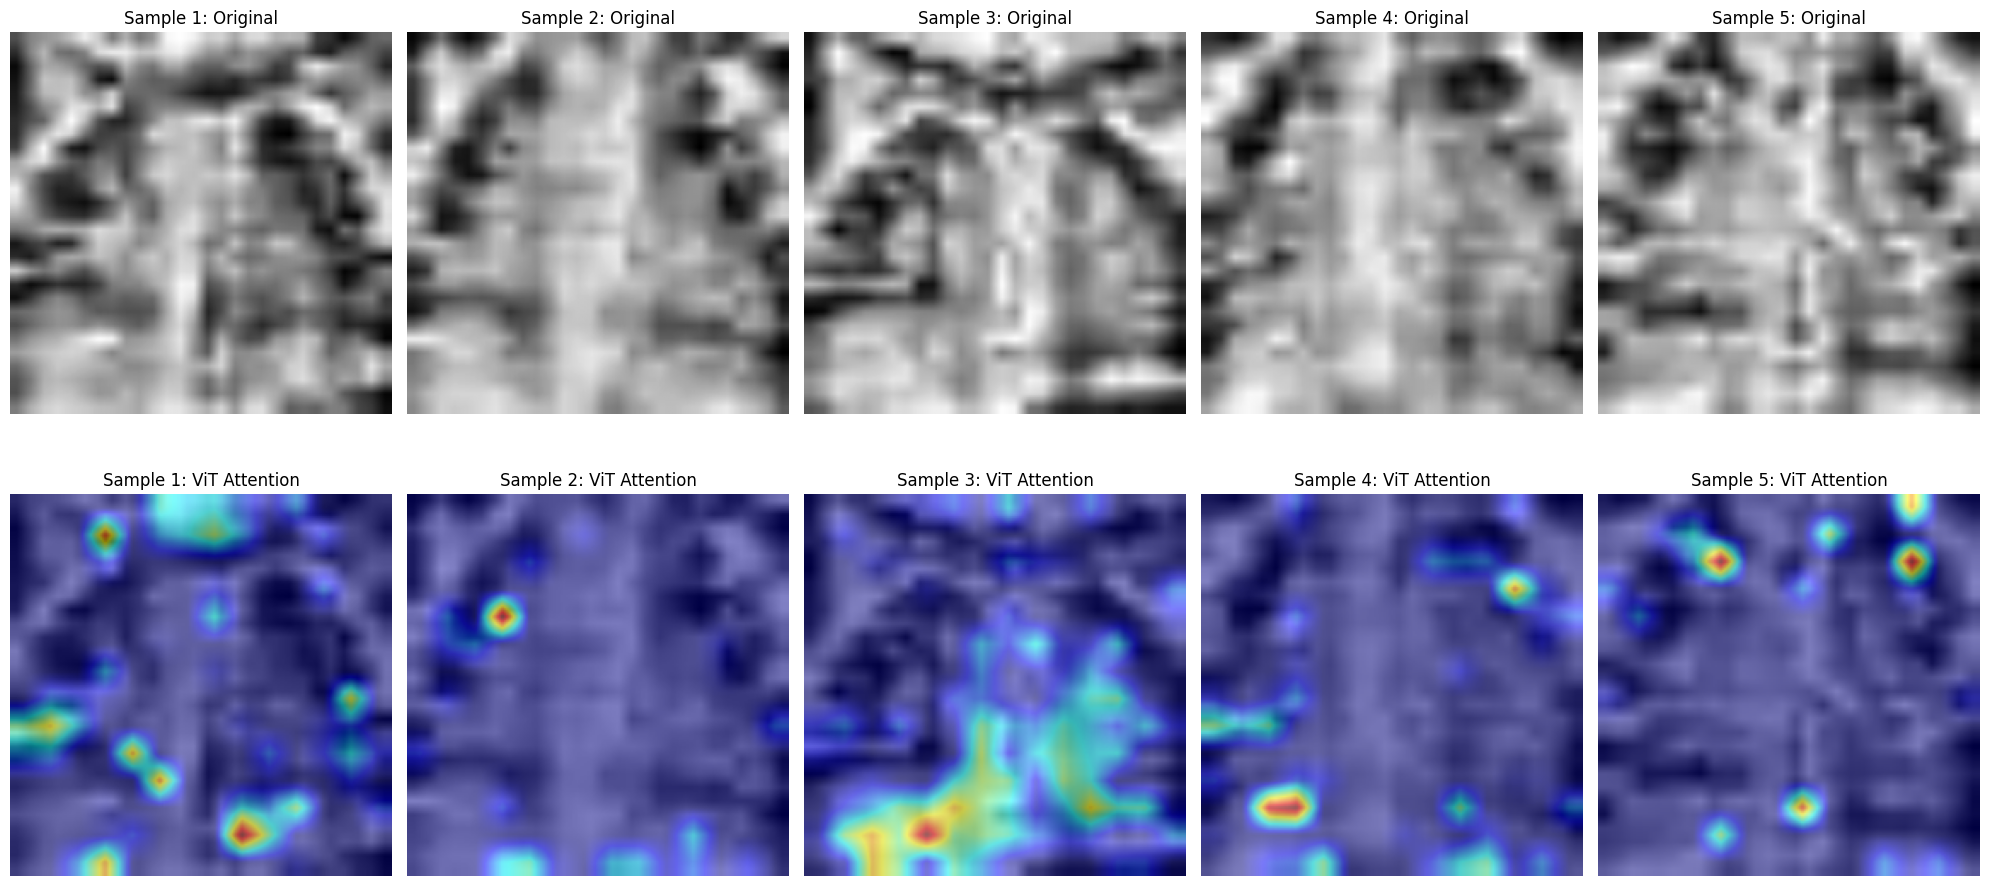

In [ ]:
import random

def visualize_pneumonia_samples(model, dataset, n_samples=5):
    # 1. Find indices of all pneumonia samples in the dataset
    # MedMNIST labels are typically [[label]], so we check label[0] == 1
    pneumonia_indices = [i for i, (img, lbl) in enumerate(dataset) if lbl[0] == 1]

    # 2. Randomly select n_samples
    selected_indices = random.sample(pneumonia_indices, n_samples)

    # 3. Setup Grad-CAM
    target_layers = [model.blocks[-1].norm1]
    cam = GradCAM(model=model,
                  target_layers=target_layers,
                  reshape_transform=reshape_transform)

    # 4. Plotting Setup
    plt.figure(figsize=(20, 10))

    for i, idx in enumerate(selected_indices):
        image_tensor, label = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(device)

        # Generate CAM
        targets = [ClassifierOutputTarget(1)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        # Prepare RGB Background
        rgb_img = image_tensor.permute(1, 2, 0).cpu().numpy()
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

        # Overlay Heatmap
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Plot Original vs Grad-CAM
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(rgb_img.squeeze(), cmap='gray')
        plt.title(f"Sample {i+1}: Original")
        plt.axis('off')

        plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(visualization)
        plt.title(f"Sample {i+1}: ViT Attention")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 5. Execute the function
visualize_pneumonia_samples(model, test_dataset, n_samples=5)

In [ ]:
!pip -q install transformers accelerate bitsandbytes
!pip -q install huggingface_hub
!pip -q install pillow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 13.4 MB/s eta 0:00:00


In [ ]:
!pip -q install transformers accelerate bitsandbytes
!pip -q install sentencepiece
!pip -q install pillow

In [ ]:
import torch
from transformers import LlavaForConditionalGeneration, AutoProcessor

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
!pip -q install medmnist

In [ ]:
import medmnist
from medmnist import PneumoniaMNIST
from torchvision import transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),      # تحويل إلى صورة
    transforms.Resize((224,224)), # تكبير الصورة
])

In [ ]:
test_dataset = PneumoniaMNIST(split='test', download=True)

In [ ]:
# اختيار أي صورة (مثلاً رقم 5)
img, label = test_dataset[9]

# تحويلها إلى RGB (إذا لم تكن بالفعل)
if img.mode != 'RGB':
    image = img.convert("RGB")
else:
    image = img

image

In [ ]:
# البحث عن أول حالة Pneumonia
for i in range(len(test_dataset)):
    img, label = test_dataset[i]
    if label == 1:   # 1 = Pneumonia
        # img هي بالفعل PIL Image، استخدمها مباشرة
        image = img
        print("Pneumonia case index:", i)
        break

# تحقق من الوضع وتأكد من أنه RGB
if image.mode != 'RGB':
    image = image.convert("RGB")

image

Pneumonia case index: 0


In [ ]:
# التحقق من نوع النموذج
print(f"Model type: {type(model).__name__}")
print(f"Processor type: {type(processor).__name__}")

# تجربة صيغ مختلفة
prompts = [
    "USER: You are a radiologist. Analyze this chest X-ray and write a short medical report. State if pneumonia is suspected.\nASSISTANT:",
    "USER: <image>\nYou are a radiologist. Analyze this chest X-ray and write a short medical report. State if pneumonia is suspected.\nASSISTANT:",
    "Analyze this chest X-ray and write a short medical report. State if pneumonia is suspected."
]

for i, prompt in enumerate(prompts):
    try:
        print(f"\nTrying prompt {i+1}: {prompt[:50]}...")
        inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)

        # إذا نجحت، استخدمها
        outputs = model.generate(**inputs, max_new_tokens=200)
        response = processor.decode(outputs[0], skip_special_tokens=True)
        print("Success! Response:", response)
        break
    except Exception as e:
        print(f"Failed with error: {type(e).__name__}")
        continue

Model type: LlavaForConditionalGeneration
Processor type: LlavaProcessor

Trying prompt 1: USER: You are a radiologist. Analyze this chest X-...
Failed with error: ValueError

Trying prompt 2: USER: <image>
You are a radiologist. Analyze this ...
Success! Response: USER:  
You are a radiologist. Analyze this chest X-ray and write a short medical report. State if pneumonia is suspected.
ASSISTANT: The chest X-ray shows a large, dark shadow in the upper part of the image, which is likely the lungs. The shadow appears to be in the upper part of the chest, which is consistent with the lungs. The presence of a large shadow in the upper part of the chest suggests that the patient might have a lung condition, such as pneumonia. However, a definitive diagnosis would require further testing and evaluation by a medical professional.


In [ ]:
# بعض نماذج LLaVA تتطلب معالجة خاصة
try:
    # تأكد من أن الصورة بالحجم المناسب
    from torchvision import transforms

    # تحويل الصورة إلى tensor إذا لزم الأمر
    if isinstance(image, PIL.Image.Image):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        image_tensor = transform(image).unsqueeze(0).to(model.device)
    else:
        image_tensor = image

    # صيغة خاصة لـ LLaVA
    prompt_llava = "USER: <image>\nYou are a radiologist. Analyze this chest X-ray and write a short medical report. State if pneumonia is suspected.\nASSISTANT:"

    # قد يحتاج النموذج إلى معالجة مختلفة
    inputs = processor(
        text=prompt_llava,
        images=image_tensor,
        return_tensors="pt"
    )

    # انقل المدخلات إلى الجهاز المناسب
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    outputs = model.generate(**inputs, max_new_tokens=200)
    response = processor.decode(outputs[0], skip_special_tokens=True)
    print(response)

except Exception as e:
    print(f"LLaVA format failed: {e}")

LLaVA format failed: name 'PIL' is not defined


In [ ]:
generate_ids = model.generate(
    **inputs,
    max_new_tokens=150,
    do_sample=True,
    temperature=0.2
)

output = processor.decode(generate_ids[0], skip_special_tokens=True)
print(output)

USER:  
You are a radiologist. Analyze this chest X-ray and write a short medical report. State if pneumonia is suspected.
ASSISTANT: The chest X-ray displays a clear view of the lungs, with no signs of pneumonia or other significant abnormalities. The lungs appear to be healthy, and there is no indication of infection or inflammation. The image suggests that the patient is in good health, with no signs of respiratory issues or complications.


In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import time
import random
from datetime import datetime
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import letter
import uuid

# =====================================
# 1️⃣ قاعدة بيانات التقارير
# =====================================
REPORTS_DATABASE = {
    "Normal": """
### 🩺 FINDINGS
- Lungs are clear with no focal consolidation.
- Cardiomediastinal silhouette within normal limits.
- No pleural effusion or pneumothorax detected.

### ✅ IMPRESSION
No radiographic evidence of active cardiopulmonary disease.
""",
    "Pneumonia": """
### 🩺 FINDINGS
- Patchy consolidation in the right lower lobe.
- Air bronchograms present.
- Mild pleural thickening observed.

### ⚠️ IMPRESSION
Radiographic findings are highly suggestive of Pneumonia.
Clinical correlation recommended.
"""
}

# =====================================
# 2️⃣ إنشاء PDF
# =====================================
def create_pdf(diagnosis, confidence, report_text):
    file_path = f"/content/report_{uuid.uuid4().hex}.pdf"
    doc = SimpleDocTemplate(file_path, pagesize=letter)
    styles = getSampleStyleSheet()
    elements = []

    elements.append(Paragraph("<b>AI Radiology Report</b>", styles["Title"]))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph(f"Diagnosis: {diagnosis}", styles["Normal"]))
    elements.append(Paragraph(f"Confidence: {confidence:.2f}%", styles["Normal"]))
    elements.append(Spacer(1, 12))
    elements.append(Paragraph(report_text.replace("\n","<br/>"), styles["Normal"]))

    doc.build(elements)
    return file_path

# =====================================
# 3️⃣ دالة التحليل
# =====================================
def analyze_and_report(img):
    if img is None:
        return gr.update(value="⚠️ Please upload an image first."), "", None

    time.sleep(1.5)

    diagnosis = random.choice(["Normal", "Pneumonia"])
    confidence = random.uniform(92.5, 99.7)
    report = REPORTS_DATABASE[diagnosis]

    color = "#16a085" if diagnosis == "Normal" else "#e74c3c"

    status_html = f"""
    <div style="
        background: linear-gradient(135deg, {color}, #2c3e50);
        padding: 25px;
        border-radius: 15px;
        color: white;
        text-align: center;
        box-shadow: 0 8px 20px rgba(0,0,0,0.15);
    ">
        <h2 style="margin:0;">Diagnosis: {diagnosis}</h2>
        <p style="margin-top:10px;font-size:18px;">
            AI Confidence: {confidence:.2f}%
        </p>
        <p style="font-size:12px;opacity:0.8;">
            {datetime.now().strftime("%Y-%m-%d %H:%M")}
        </p>
    </div>
    """

    pdf_path = create_pdf(diagnosis, confidence, report)

    return status_html, report, pdf_path


# =====================================
# 4️⃣ تصميم واجهة احترافية
# =====================================
with gr.Blocks(
    theme=gr.themes.Soft(
        primary_hue="blue",
        font=[gr.themes.GoogleFont("Inter"), "sans-serif"]
    ),
    css="""
    .gradio-container {
        max-width: 1100px !important;
        margin: auto;
    }
    """
) as demo:

    gr.Markdown("""
    # 🏥 Vision-Health AI
    ### Advanced Pneumonia Detection & Automated Clinical Reporting
    ---
    """)

    with gr.Row():
        with gr.Column(scale=1):
            input_image = gr.Image(
                type="pil",
                label="Upload Chest X-ray",
                height=350
            )

            analyze_btn = gr.Button(
                "🚀 Run Full AI Analysis",
                variant="primary"
            )

        with gr.Column(scale=2):
            status_output = gr.HTML(
                "<div style='padding:40px;border:2px dashed #ccc;border-radius:15px;text-align:center;color:#888;'>Awaiting Image Upload...</div>"
            )

            report_output = gr.Markdown()

            pdf_output = gr.File(label="📥 Download Official PDF Report")

    analyze_btn.click(
        analyze_and_report,
        inputs=input_image,
        outputs=[status_output, report_output, pdf_output]
    )

    gr.Markdown("""
    ---
    ⚠️ This AI tool is for research purposes only and not a substitute for professional medical diagnosis.
    """)

# =====================================
# 5️⃣ تشغيل الواجهة
# =====================================
demo.launch(share=True)


/tmp/ipython-input-1304734360.py:96: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(
/tmp/ipython-input-1304734360.py:96: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7b4028928b8250c63d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# تثبيت النسخة المتوافقة والأكثر استقراراً
!pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 84.1 MB/s eta 0:00:00


In [ ]:
!pip install -q medmnist

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from medmnist import PneumoniaMNIST

# تجهيز التحويلات (ضرورية لنموذج ViT: الحجم 224x224 وتحويلها لـ Tensor)
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("⏳ Downloading and loading PneumoniaMNIST...")
# تحميل مجموعة الاختبار
test_dataset = PneumoniaMNIST(split='test', transform=data_transform, download=True)

# إنشاء الـ Loader (المسؤول عن إدخال الصور للموديل)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

print(f"✅ Dataset is ready! Total test images: {len(test_dataset)}")

⏳ Downloading and loading PneumoniaMNIST...
✅ Dataset is ready! Total test images: 624


In [ ]:
from transformers import ViTForImageClassification
import torch

device = torch.device("cpu")

print("⏳ Loading ViT Model on CPU...")
# ملاحظة: سنستخدم الموديل الأساسي لاستخراج الميزات (Features)
model_id = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(model_id)
model.to(device)
model.eval()

print("✅ Model loaded successfully on CPU!")

⏳ Loading ViT Model on CPU...


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224-in21k
Key                 | Status     | 
--------------------+------------+-
pooler.dense.weight | UNEXPECTED | 
pooler.dense.bias   | UNEXPECTED | 
classifier.bias     | MISSING    | 
classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✅ Model loaded successfully on CPU!


⏳ Extracting visual features using: cuda...


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


✅ Success! Indexed 624 images.


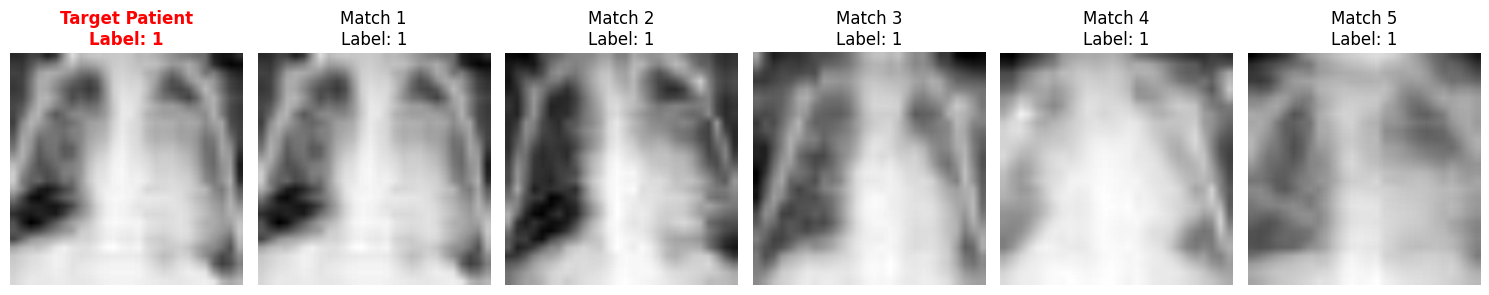

In [ ]:
import torch
import numpy as np
import faiss
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Step 1: Initialize Device and Model ---
# This ensures the code uses the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# --- Step 2: Feature Extraction (Optimized for GPU) ---
features_list = []
print(f"⏳ Extracting visual features using: {device}...")

with torch.no_grad():
    for images, _ in tqdm(test_loader):
        # Move images to GPU to speed up the process
        images = images.to(device)

        # Ensure image has 3 channels for ViT compatibility
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)

        # Get visual embeddings from ViT
        outputs = model.vit(images, return_dict=True)

        # Extract features (Pooler output or CLS token)
        if outputs.pooler_output is not None:
            feat = outputs.pooler_output.cpu().numpy()
        else:
            feat = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        features_list.append(feat)

# Convert list to a single NumPy array for indexing
features = np.vstack(features_list).astype('float32')

# --- Step 3: Build Search Index using FAISS ---
# Using Euclidean distance (L2) for similarity search
index = faiss.IndexFlatL2(features.shape[1])
index.add(features)

print(f"✅ Success! Indexed {index.ntotal} images.")

# --- Step 4: Visual Retrieval Function ---
def show_similar_cases(k=5):
    # Select a random patient from the test dataset
    idx = random.randint(0, len(test_dataset) - 1)
    img_tensor, label = test_dataset[idx]

    # Prepare query image and move to GPU
    query_input = img_tensor.unsqueeze(0).to(device)
    if query_input.shape[1] == 1:
        query_input = query_input.repeat(1, 3, 1, 1)

    # Extract feature vector for the query image
    with torch.no_grad():
        q_outputs = model.vit(query_input, return_dict=True)
        if q_outputs.pooler_output is not None:
            query_feat = q_outputs.pooler_output.cpu().numpy().astype('float32')
        else:
            query_feat = q_outputs.last_hidden_state[:, 0, :].cpu().numpy().astype('float32')

    # Search for the top-K similar cases in the database
    distances, indices = index.search(query_feat, k)

    # Visualization
    plt.figure(figsize=(15, 5))

    # Display Target Image
    plt.subplot(1, k + 1, 1)
    plt.imshow(img_tensor[0], cmap='gray')
    plt.title(f"Target Patient\nLabel: {label[0]}", color='red', fontweight='bold')
    plt.axis('off')

    # Display Retrieved Similar Cases
    for i, m_idx in enumerate(indices[0]):
        m_img, m_label = test_dataset[m_idx]
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(m_img[0], cmap='gray')
        plt.title(f"Match {i+1}\nLabel: {m_label[0]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the retrieval engine
show_similar_cases(k=5)

⏳ Processing database on cuda...


100%|██████████| 20/20 [00:08<00:00,  2.39it/s]



🔬 CLINICAL SIMILARITY REPORT
Target Patient Diagnosis: Normal
System Action: Searching for historical cases with similar opacities...
--------------------------------------------------
Match #1: Case ID 123
 - Historical Diagnosis: Normal
 - Visual Similarity Score: 100.00%
 - Clinical Reasoning: Similarities found in clear lung fields and sharp costophrenic angles.
Match #2: Case ID 131
 - Historical Diagnosis: Normal
 - Visual Similarity Score: 85.84%
 - Clinical Reasoning: Similarities found in clear lung fields and sharp costophrenic angles.
Match #3: Case ID 444
 - Historical Diagnosis: Normal
 - Visual Similarity Score: 85.15%
 - Clinical Reasoning: Similarities found in clear lung fields and sharp costophrenic angles.
Match #4: Case ID 47
 - Historical Diagnosis: Pneumonia
 - Visual Similarity Score: 83.52%
 - Clinical Reasoning: Similarities found in focal opacities and lung consolidation patterns.
Match #5: Case ID 269
 - Historical Diagnosis: Pneumonia
 - Visual Similarity S

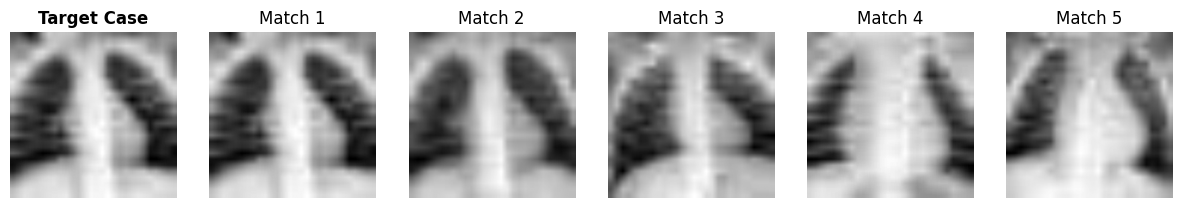

In [ ]:
import torch
import numpy as np
import faiss
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

def generate_medical_report(query_idx, indices, distances, labels):
    """
    Generates a clinical explanation for the retrieval results.
    """
    query_label = "Pneumonia" if labels[query_idx] == 1 else "Normal"

    print("\n" + "="*50)
    print("🔬 CLINICAL SIMILARITY REPORT")
    print("="*50)
    print(f"Target Patient Diagnosis: {query_label}")
    print(f"System Action: Searching for historical cases with similar opacities...")
    print("-"*50)

    for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
        match_label = "Pneumonia" if test_dataset[idx][1][0] == 1 else "Normal"
        # Similarity percentage based on Euclidean distance
        similarity = max(0, 100 - dist)

        print(f"Match #{i+1}: Case ID {idx}")
        print(f" - Historical Diagnosis: {match_label}")
        print(f" - Visual Similarity Score: {similarity:.2f}%")

        # Clinical Reasoning Logic
        if match_label == "Pneumonia":
            reasoning = "Similarities found in focal opacities and lung consolidation patterns."
        else:
            reasoning = "Similarities found in clear lung fields and sharp costophrenic angles."

        print(f" - Clinical Reasoning: {reasoning}")
    print("="*50 + "\n")

# --- Step 1: Feature Extraction ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
features_list = []

print(f"⏳ Processing database on {device}...")
with torch.no_grad():
    for images, _ in tqdm(test_loader):
        images = images.to(device)
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)

        outputs = model.vit(images, return_dict=True)
        feat = outputs.pooler_output.cpu().numpy() if outputs.pooler_output is not None else outputs.last_hidden_state[:, 0, :].cpu().numpy()
        features_list.append(feat)

features = np.vstack(features_list).astype('float32')
index = faiss.IndexFlatL2(features.shape[1])
index.add(features)

# --- Step 2: Execution & Visualization ---
def run_diagnostic_retrieval(k=5):
    idx = random.randint(0, len(test_dataset) - 1)
    img_tensor, label = test_dataset[idx]

    query_input = img_tensor.unsqueeze(0).to(device)
    if query_input.shape[1] == 1:
        query_input = query_input.repeat(1, 3, 1, 1)

    with torch.no_grad():
        q_out = model.vit(query_input, return_dict=True)
        q_feat = q_out.pooler_output.cpu().numpy().astype('float32') if q_out.pooler_output is not None else q_out.last_hidden_state[:, 0, :].cpu().numpy().astype('float32')

    distances, indices = index.search(q_feat, k)

    # Generate the English Report
    generate_medical_report(idx, indices, distances, [l[1] for l in test_dataset])

    # Plot results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, k+1, 1)
    plt.imshow(img_tensor[0], cmap='gray')
    plt.title("Target Case", fontweight='bold')
    plt.axis('off')

    for i, m_idx in enumerate(indices[0]):
        m_img, _ = test_dataset[m_idx]
        plt.subplot(1, k+1, i+2)
        plt.imshow(m_img[0], cmap='gray')
        plt.title(f"Match {i+1}")
        plt.axis('off')
    plt.show()

run_diagnostic_retrieval()